In [4]:
from pyspark.sql import SparkSession
spark = SparkSession\
.builder\
.config("spark.submit.deployMode", "client")\
.config("spark.executor.instances", "1")\
.config("spark.executor.memory", "1g")\
.config("spark.driver.memory", "1g")\
.config("spark.executor.memoryOverhead", "1g")\
.appName("transporte")\
.master("spark://sparkmaster:7077")\
.getOrCreate()

spark.sparkContext._conf.getAll()

[('spark.app.startTime', '1657476351160'),
 ('spark.driver.host', 'sparkmaster'),
 ('spark.driver.port', '33277'),
 ('spark.app.id', 'app-20220710180551-0001'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'transporte'),
 ('spark.driver.memory', '1g'),
 ('spark.master', 'spark://sparkmaster:7077'),
 ('spark.sql.warehouse.dir',
  'file:/home/userpython/MR_probando/spark-warehouse'),
 ('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.instances', '1'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.executor.memoryOverhead', '1g')]

In [5]:
#Se crea el dataframe
data = spark.read.csv('hdfs://namenode:9000/cursoFAI/transporte.csv', header=True,  inferSchema=True)

In [6]:
#Se realizan unas limpiezas
from pyspark.sql.types import StringType, FloatType
data2 = data.withColumn("TIPO_TRANSPORTE", data["TIPO_TRANSPORTE"].cast(StringType ()))
data2 = data2.where(data2.TIPO_TRANSPORTE!="TOTAL") #quito las columnas TOTAL
data2 = data2.fillna("E", subset=['GENERO']) #reemplazo los generos none por E para listarlos

In [ ]:
#Experimento 1 - INICIO

In [7]:
#MapReduce para genero/transporte
data3=data2.rdd.map(lambda x: (x['GENERO'],x['CANT_TRJ']) ) 
data3=data3.reduceByKey(lambda a,b: a+b).sortByKey()
print(data3.collect())

[('E', 386896401), ('F', 505176718), ('M', 269324965)]


In [8]:
#Funcion para calcular el promedio de viajes por genero
data4 = data2
def avg_map_func(row):
    return (row[3], (row[5], 1))

def avg_reduce_func(value1, value2):
    return ((value1[0] + value2[0], value1[1] + value2[1])) 

data4 = data4.rdd.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: round(x[0]/x[1],2))
data4.collect()

[('E', 132498.77), ('F', 21625.72), ('M', 11529.32)]

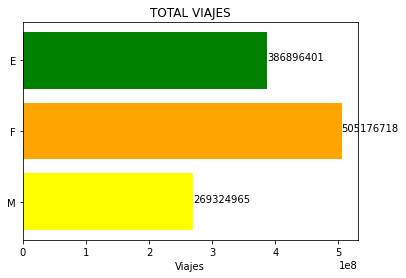

In [9]:
#Grafico que muestra el total de viajes por genero
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.types import FloatType
data3 = data2.rdd.map(lambda x: (x['GENERO'],x['CANT_TRJ']) )
data3 = data3.reduceByKey(lambda a,b: a+b).sortByKey()

np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

# Obtener valores clave y de valor
# Puede usar las funciones de claves y valores para obtener la matriz de 
# claves y la matriz de valores del RDD respectivamente:
kvRDD1 = spark.sparkContext.parallelize(data3.collect())

col_genero = kvRDD1.keys().collect()
col_cant_viajes = kvRDD1.values().collect()

y_pos = np.arange(len(col_genero))

error = np.random.rand(len(col_genero))

ax.barh(y_pos, col_cant_viajes
        , xerr=error
        , align='center'
        , color={"yellow", "green","orange"})
ax.set_yticks(y_pos)
ax.set_yticklabels(col_genero)
ax.invert_yaxis()
ax.set_xlabel('Viajes')
ax.set_title('TOTAL VIAJES')

# Para que las barras visualicen los importes
for index, value in enumerate(col_cant_viajes):
    ax.text(value, index, str(value))
plt.show()

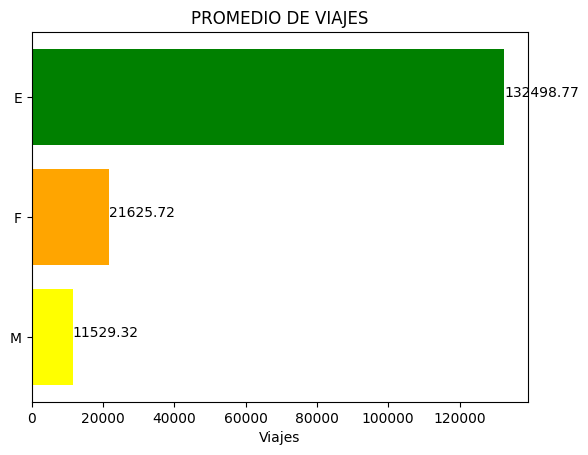

In [10]:
#Grafico de promedios de viaje por genero
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

#Obtener valores clave y de valor
# Puede usar las funciones de claves y valores 
# para obtener la matriz de claves y la matriz de valores del RDD respectivamente:
kvRDD1 = spark.sparkContext.parallelize(data4.collect())

col_genero = kvRDD1.keys().collect()
col_cant_viajes = kvRDD1.values().collect()

#print(col_genero)
#print(col_cant_viajes)
y_pos = np.arange(len(col_genero))
#print(y_pos)
error = np.random.rand(len(col_genero))

ax.barh(y_pos, col_cant_viajes
        , xerr=error
        , align='center'
        , color={"yellow", "green","orange"})
ax.set_yticks(y_pos)
ax.set_yticklabels(col_genero)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Viajes')
ax.set_title('PROMEDIO DE VIAJES')

# Para que las barras visualicen los importes
for index, value in enumerate(col_cant_viajes):
    ax.text(value, index, str(value))
plt.show()

In [ ]:
#Experimento 1 - FIN

In [ ]:
#Experimento 2 - INICIO

In [11]:
#Funcion para calcular la cantidad de viajes por mes
import datetime
import pyspark.sql.functions as F

def mapeoReduccionPrestacionMes(dataFrame_novedad):     
    elmap =  dataFrame_novedad.rdd.map(lambda x: (int(x['mes']) ,round( x['CANT_TRJ'] , 2) ) )    
    print('<<< Resultado del Map >>>')
    print (elmap.take(10)) 
    resultado = elmap.reduceByKey(lambda x,y : round(x+y,2) ).sortByKey()
    print('<<< Resultado del Reduce >>>')
    print(resultado.collect())
    return resultado

In [12]:
# Se muestran los datos necesarios para el grafico
# de viajes por genero por mes
df_con_fechas = data2
df_genero = data2.select('GENERO').distinct()

df_genero.show(10,False)
split_col = F.split(df_con_fechas['DIA_TRANSPORTE'], '-')
df_con_fechas = df_con_fechas.withColumn('anio', split_col.getItem(0))
df_con_fechas = df_con_fechas.withColumn('mes', split_col.getItem(1))

Lista={}
for row in df_genero.rdd.collect():
    x = row["GENERO"]
    print('<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>') 
    print( '>>>> Genero: ', x)    
    print('<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>') 
    df_con_fechas_tipo = df_con_fechas.filter('GENERO = "'+x+'"' )
    Lista[x] = mapeoReduccionPrestacionMes(df_con_fechas_tipo)
print('<<< LISTA >>>')    
print(Lista)

+------+
|GENERO|
+------+
|F     |
|E     |
|M     |
+------+



<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> Genero:  F
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<< Resultado del Map >>>
[(1, 13693), (1, 2), (1, 0), (1, 0), (1, 7128), (1, 0), (1, 0), (1, 0), (1, 4645), (1, 2)]
<<< Resultado del Reduce >>>
[(1, 30439601), (2, 31716883), (3, 42619046), (4, 35657455), (5, 30180322), (6, 35408820), (7, 40412092), (8, 46789137), (9, 50235558), (10, 53803271), (11, 55805241), (12, 52109292)]
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> Genero:  E
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<< Resultado del Map >>>
[(1, 33231), (1, 0), (1, 0), (1, 0), (1, 153741), (1, 0), (1, 7141), (1, 13992), (1, 95471), (1, 1)]
<<< Resultado del Reduce >>>
[(1, 23343758), (2, 24186350), (3, 32003901), (4, 26461940), (5, 22540220), (6, 26331161), (7, 30846727), (8, 35458435), (9, 38158465), (10, 41554809), (11, 43501124), (12, 42509511)]
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>

[(1, 16267334), (2, 16549597), (3, 22186927), (4, 18843395), (5, 16097478), (6, 18782248), (7, 21405737), (8, 24998299), (9, 27276964), (10, 29093102), (11, 30263524), (12, 27560360)]
<<< LISTA >>>
{'F': PythonRDD[64] at collect at /tmp/ipykernel_87/2092032048.py:11, 'E': PythonRDD[76] at collect at /tmp/ipykernel_87/2092032048.py:11, 'M': PythonRDD[88] at collect at /tmp/ipykernel_87/2092032048.py:11}


In [13]:
#Se crean mas datos para la visualizacion
dic_genero = Lista
lista_viajes_mensuales = []
lista_genero = dic_genero.keys()

for key in dic_genero:
    lista_viajes_por_genero = []
    lista_viajes_por_genero = dic_genero[key].values().collect()
    lista_viajes_mensuales.extend( [dic_genero[key].values().collect()])
    lista_mes = dic_genero[key].keys().collect()

<Figure size 1600x1000 with 0 Axes>

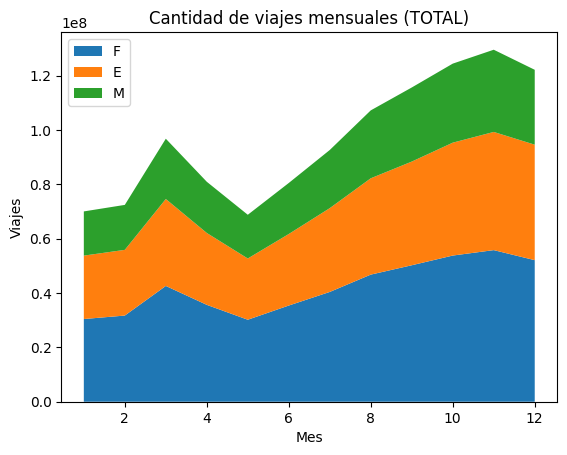

In [14]:
#Se genera el grafico de viajes por genero por mes
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
fig, ax = plt.subplots()
ax.stackplot(lista_mes,lista_viajes_mensuales,labels=lista_genero)
ax.legend(loc='upper left')
ax.set_title('Cantidad de viajes mensuales (TOTAL)')
ax.set_xlabel('Mes')
ax.set_ylabel('Viajes')

plt.show()

In [ ]:
#Experimento 2 - FIN

In [ ]:
#Experimento 3 - INICIO

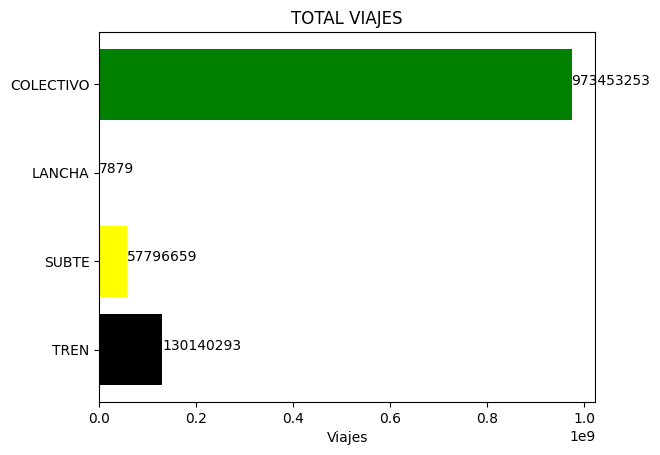

In [15]:
#Grafico para el total viajes por medio de transporte
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.types import FloatType
data3 = data2.rdd.map(lambda x: (x['TIPO_TRANSPORTE'],x['CANT_TRJ']) )
data3 = data3.reduceByKey(lambda a,b: a+b).sortByKey()

data3.collect()

np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

#Obtener valores clave y de valor
# Puede usar las funciones de claves y valores para obtener 
# la matriz de claves y la matriz de valores del RDD respectivamente:
kvRDD1 = spark.sparkContext.parallelize(data3.collect())

col_genero = kvRDD1.keys().collect()
col_cant_viajes = kvRDD1.values().collect()

y_pos = np.arange(len(col_genero))

error = np.random.rand(len(col_genero))

ax.barh(y_pos, col_cant_viajes
        , xerr=error
        , align='center'
        , color={"yellow", "green","orange","black"})
ax.set_yticks(y_pos)
ax.set_yticklabels(col_genero)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Viajes')
ax.set_title('TOTAL VIAJES')

# Para que las barras visualicen los importes
for index, value in enumerate(col_cant_viajes):
    ax.text(value, index, str(value))
plt.show()

In [ ]:
#Experimento 3 - FIN

In [ ]:
#Experimento 4 - INICIO

In [16]:
#Map reduce para mostrar la cantidad de viajes por medio de transporte
data4=data2
def avg_map_func(row):
    return (row[4], (row[5], 1))

def avg_reduce_func(value1, value2):
    return ((value1[0] + value2[0], value1[1] + value2[1])) 

data4 = data4.rdd.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: round(x[0]/x[1],2))
data4.collect()

[('COLECTIVO', 78441.04),
 ('LANCHA', 0.63),
 ('SUBTE', 4657.27),
 ('TREN', 10486.73)]

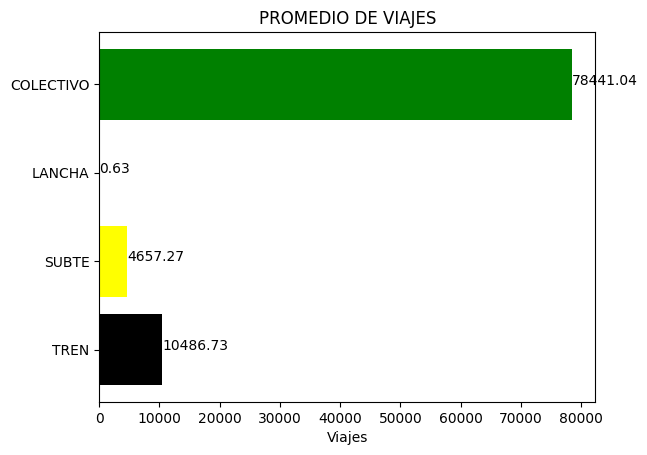

In [17]:
#Promedios de viaje por medio de transporte
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

#Obtener valores clave y de valor
# Puede usar las funciones de claves y valores para obtener 
#la matriz de claves y la matriz de valores del RDD respectivamente:
kvRDD1 = spark.sparkContext.parallelize(data4.collect())

col_genero = kvRDD1.keys().collect()
col_cant_viajes = kvRDD1.values().collect()

#print(col_genero)
#print(col_cant_viajes)
y_pos = np.arange(len(col_genero))
#print(y_pos)
error = np.random.rand(len(col_genero))

ax.barh(y_pos, col_cant_viajes
        , xerr=error
        , align='center'
        , color={"yellow", "green","orange","black"})
ax.set_yticks(y_pos)
ax.set_yticklabels(col_genero)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Viajes')
ax.set_title('PROMEDIO DE VIAJES')

# Para que las barras visualicen los importes
for index, value in enumerate(col_cant_viajes):
    ax.text(value, index, str(value))
plt.show()

In [ ]:
#Experimento 4 - FIN

In [ ]:
#Experimento 5 - INICIO

In [18]:
#MapReduce para el calculo de viajes totales por mes por medio de
#transporte
import datetime
import pyspark.sql.functions as F

def mapeoReduccionPrestacionMes(dataFrame_novedad):     
    elmap =  dataFrame_novedad.rdd.map(lambda x: (int(x['mes']) ,round( x['CANT_TRJ'] , 2) ) )    
    print('<<< Resultado del Map >>>')
    print (elmap.take(10)) 
    resultado = elmap.reduceByKey(lambda x,y : round(x+y,2) ).sortByKey()
    print('<<< Resultado del Reduce >>>')
    print(resultado.collect())
    return resultado

In [19]:
#Se muestran los datos para los graficos
df_con_fechas = data2
df_genero = data2.select('TIPO_TRANSPORTE').distinct()

df_genero.show(10,False)
split_col = F.split(df_con_fechas['DIA_TRANSPORTE'], '-')
df_con_fechas = df_con_fechas.withColumn('anio', split_col.getItem(0))
df_con_fechas = df_con_fechas.withColumn('mes', split_col.getItem(1))

Lista={}
for row in df_genero.rdd.collect():
    x = row["TIPO_TRANSPORTE"]
    print('<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>') 
    print( '>>>> TIPO_TRANSPORTE: ', x)    
    print('<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>') 
    df_con_fechas_tipo = df_con_fechas.filter('TIPO_TRANSPORTE = "'+x+'"' )
    Lista[x] = mapeoReduccionPrestacionMes(df_con_fechas_tipo)
print('<<< LISTA >>>')    
print(Lista)

+---------------+
|TIPO_TRANSPORTE|
+---------------+
|LANCHA         |
|SUBTE          |
|TREN           |
|COLECTIVO      |
+---------------+



<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> TIPO_TRANSPORTE:  LANCHA
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<< Resultado del Map >>>
[(1, 0), (1, 2), (1, 4), (1, 0), (1, 0), (1, 2), (1, 2), (1, 0), (1, 0), (1, 0)]
<<< Resultado del Reduce >>>
[(1, 874), (2, 854), (3, 933), (4, 768), (5, 608), (6, 443), (7, 548), (8, 530), (9, 544), (10, 551), (11, 611), (12, 615)]
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> TIPO_TRANSPORTE:  SUBTE
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<< Resultado del Map >>>
[(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0)]
<<< Resultado del Reduce >>>
[(1, 2566674), (2, 2781489), (3, 4024232), (4, 3076494), (5, 2466918), (6, 3164209), (7, 4128614), (8, 5228310), (9, 6302974), (10, 7270190), (11, 8190505), (12, 8596050)]
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> TIPO_TRANSPORTE:  TREN
<<<<<<<<<<<<<<<

In [20]:
#Se generan mas datos para el grafico
dic_genero = Lista
lista_viajes_mensuales = []
lista_genero = dic_genero.keys()

for key in dic_genero: 
    lista_viajes_por_genero = []
    lista_viajes_por_genero = dic_genero[key].values().collect()
    lista_viajes_mensuales.extend( [dic_genero[key].values().collect()])
    lista_mes = dic_genero[key].keys().collect()

<Figure size 1600x1000 with 0 Axes>

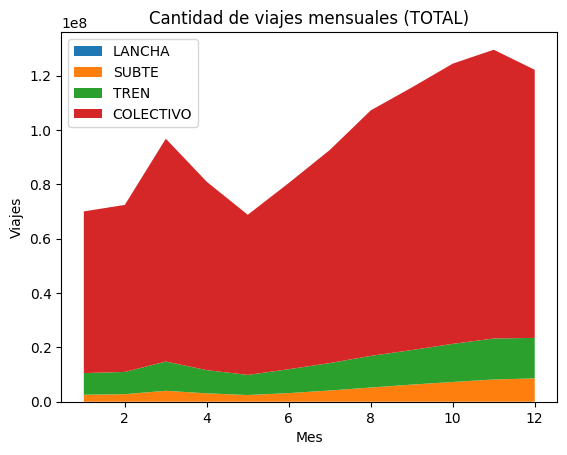

In [21]:
#Grafico para el total de viajes por mes por
#medio de transporte
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
fig, ax = plt.subplots()
ax.stackplot(lista_mes,lista_viajes_mensuales,labels=lista_genero)
ax.legend(loc='upper left')
ax.set_title('Cantidad de viajes mensuales (TOTAL)')
ax.set_xlabel('Mes')
ax.set_ylabel('Viajes')

plt.show()

In [ ]:
#Experimento 5 - FIN

In [ ]:
#Experimento 6 - INICIO

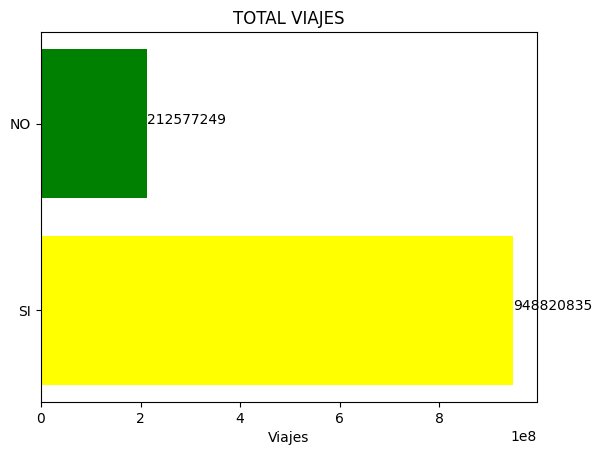

In [22]:
#TOTAL viajes por zona
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.types import FloatType
#data2 = data.withColumn("CANT_TRJ", data["CANT_TRJ"].cast(FloatType ()))
data2 = data2.na.drop(subset=["AMBA"])
data3 = data2.rdd.map(lambda x: (x['AMBA'],x['CANT_TRJ']) )
data3 = data3.reduceByKey(lambda a,b: a+b).sortByKey()

np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

#Obtener valores clave y de valor
# Puede usar las funciones de claves y valores para obtener 
# la matriz de claves y la matriz de valores del RDD respectivamente:
kvRDD1 = spark.sparkContext.parallelize(data3.collect())

col_genero = kvRDD1.keys().collect()
col_cant_viajes = kvRDD1.values().collect()

y_pos = np.arange(len(col_genero))

error = np.random.rand(len(col_genero))

ax.barh(y_pos, col_cant_viajes
        , xerr=error
        , align='center'
        , color={"yellow", "green"})
ax.set_yticks(y_pos)
ax.set_yticklabels(col_genero)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Viajes')
ax.set_title('TOTAL VIAJES')

# Para que las barras visualicen los importes
for index, value in enumerate(col_cant_viajes):
    ax.text(value, index, str(value))
plt.show()

In [ ]:
#Experimento 6 - FIN

In [ ]:
#Experimento 7 - INICIO

In [23]:
#MapReduce para el calculo del promedio
# de viajes por zona
data4=data2
def avg_map_func(row):
    return (row[1], (row[5], 1))

def avg_reduce_func(value1, value2):
    return ((value1[0] + value2[0], value1[1] + value2[1])) 

data4 = data4.rdd.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: round(x[0]/x[1],2))

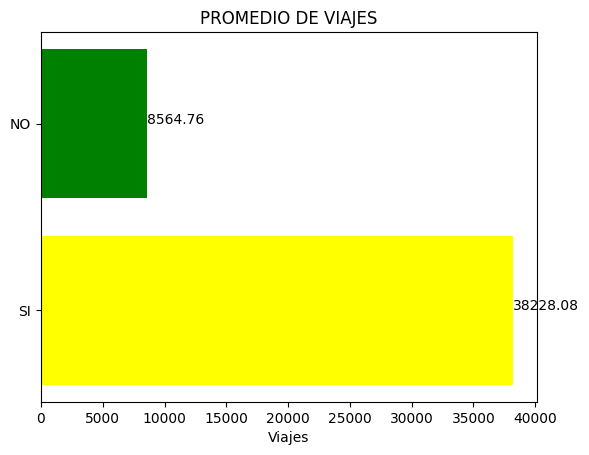

In [24]:
#Grafico de promedios de viajes por zona
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

#Obtener valores clave y de valor
# Puede usar las funciones de claves y valores para obtener 
# la matriz de claves y la matriz de valores del RDD respectivamente:
kvRDD1 = spark.sparkContext.parallelize(data4.collect())

col_genero = kvRDD1.keys().collect()
col_cant_viajes = kvRDD1.values().collect()

y_pos = np.arange(len(col_genero))

error = np.random.rand(len(col_genero))

ax.barh(y_pos, col_cant_viajes
        , xerr=error
        , align='center'
        , color={"yellow", "green"})
ax.set_yticks(y_pos)
ax.set_yticklabels(col_genero)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Viajes')
ax.set_title('PROMEDIO DE VIAJES')

# Para que las barras visualicen los importes
for index, value in enumerate(col_cant_viajes):
    ax.text(value, index, str(value))
plt.show()

In [ ]:
#Experimento 7 - FIN

In [ ]:
#Experimento 8 - INICIO

In [25]:
#MapReduce para el calculo de viajes por mes por zona
import datetime
import pyspark.sql.functions as F

def mapeoReduccionPrestacionMes(dataFrame_novedad):     
    elmap =  dataFrame_novedad.rdd.map(lambda x: (int(x['mes']) ,round( x['CANT_TRJ'] , 2) ) )    
    print('<<< Resultado del Map >>>')
    print (elmap.take(10)) 
    resultado = elmap.reduceByKey(lambda x,y : round(x+y,2) ).sortByKey()
    print('<<< Resultado del Reduce >>>')
    print(resultado.collect())
    return resultado

In [26]:
#Se muestran datos del grafico
df_con_fechas = data2
df_genero = data2.select('AMBA').distinct()

df_genero.show(10,False)
split_col = F.split(df_con_fechas['DIA_TRANSPORTE'], '-')
df_con_fechas = df_con_fechas.withColumn('anio', split_col.getItem(0))
df_con_fechas = df_con_fechas.withColumn('mes', split_col.getItem(1))

Lista={}
for row in df_genero.rdd.collect():
    x = row["AMBA"]
    print('<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>') 
    print( '>>>> AMBA: ', x)    
    print('<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>') 
    df_con_fechas_tipo = df_con_fechas.filter('AMBA = "'+x+'"' )
    Lista[x] = mapeoReduccionPrestacionMes(df_con_fechas_tipo)
print('<<< LISTA >>>')    
print(Lista)

+----+
|AMBA|
+----+
|SI  |
|NO  |
+----+



<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> AMBA:  SI
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<< Resultado del Map >>>
[(1, 153741), (1, 0), (1, 7141), (1, 13992), (1, 74900), (1, 0), (1, 3019), (1, 7416), (1, 80699), (1, 0)]
<<< Resultado del Reduce >>>
[(1, 57819491), (2, 59494345), (3, 78946766), (4, 64069140), (5, 55494795), (6, 65895898), (7, 76816673), (8, 87553843), (9, 93773444), (10, 101270465), (11, 105628188), (12, 102057787)]
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>> AMBA:  NO
<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<< Resultado del Map >>>
[(1, 33231), (1, 0), (1, 0), (1, 0), (1, 13693), (1, 2), (1, 0), (1, 0), (1, 12866), (1, 4)]
<<< Resultado del Reduce >>>
[(1, 12231202), (2, 12958485), (3, 17863108), (4, 16893650), (5, 13323225), (6, 14626331), (7, 15847883), (8, 19692028), (9, 21897543), (10, 23180717), (11, 23941701), (12, 20121376)]
<<< LISTA >>>
{'SI': Pyth

In [27]:
#Se generan los datos para el grafico
dic_genero = Lista
lista_viajes_mensuales = []
lista_genero = dic_genero.keys()

for key in dic_genero:
    lista_viajes_por_genero = []
    lista_viajes_por_genero = dic_genero[key].values().collect()
    #print ( dic_genero[key].values().collect())
    lista_viajes_mensuales.extend( [dic_genero[key].values().collect()])
    lista_mes = dic_genero[key].keys().collect()

<Figure size 1600x1000 with 0 Axes>

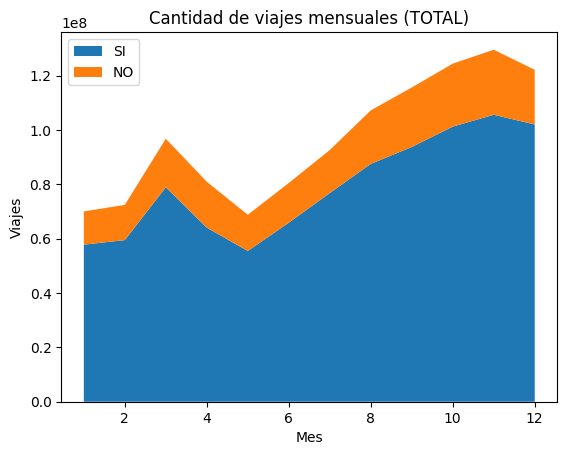

In [28]:
#Grafico para ver el total de viajes por 
#medio de transporte por mes
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
fig, ax = plt.subplots()
ax.stackplot(lista_mes,lista_viajes_mensuales,labels=lista_genero)
ax.legend(loc='upper left')
ax.set_title('Cantidad de viajes mensuales (TOTAL)')
ax.set_xlabel('Mes')
ax.set_ylabel('Viajes')

plt.show()

In [ ]:
#Experimento 8 - FIN

In [29]:
#cerramos la sesion de spark
spark.sparkContext.stop()